# The Battle of the Neighborhoods - Rivalry on the Rhine

## 0. Import necessary libraries and define common functions  

In [1]:
# import libraries


import numpy as np
import pandas as pd

import requests
from bs4 import BeautifulSoup

try:
    from geopy.geocoders import Nominatim
except:
    !conda install -c conda-forge geopy --yes
    from geopy.geocoders import Nominatim

# Matplotlib and associated plotting modules
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means clustering and metrics
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import pairwise_distances

try:
    import folium # map rendering library
except:
    !conda install -c conda-forge folium --yes  
    import folium

try:
    from wordcloud import WordCloud, STOPWORDS
except:
    !conda install -c conda-forge wordcloud --yes
    from wordcloud import WordCloud, STOPWORDS

print('Libraries imported.\n')

# use German local
import locale
print('Set the locale to {}'.format(locale.setlocale(locale.LC_ALL, 'de_DE')))

Libraries imported.

Set the locale to de_DE


## 1. Boroughs and Neighborhoods in Cologne and Düsseldorf

A list of boroughs/neighborhoods in Cologne and Düsseldorf is extracted from wiki page and converted into two dataframes together with their geospatial coordinates. The Folium library is used to visualize the city map and the neighborhood distribution.

### 1.0 Creating a function extracting geospatial coordinates for a given address

In [2]:
# A function extracting geospatial coordinates for a given address
def get_coordinatesfor(address):
    geolocator = Nominatim(user_agent="My_application", timeout=None)
    location = geolocator.geocode(address)
    return location.latitude, location.longitude

### 1.1 Cologne

#### Build dataframes containing neighborhoods

In [3]:
url = "https://de.wikipedia.org/wiki/Liste_der_Stadtbezirke_und_Stadtteile_K%C3%B6lns"
req = requests.get(url)
soup = BeautifulSoup(req.content,'lxml')
table = soup.find_all('table')[1]
df_tmp = pd.read_html(str(table), thousands='.', decimal=',')[0]

column_names = ['Neighborhood', 'Borough', 'Area', 'Population', 'Density', 'Latitude', 'Longitude']
nb_cologne = pd.DataFrame(columns=column_names)

borough = "Stadtbezirk Innenstadt"
for i in range(0, df_tmp.shape[0]):
    data = df_tmp.loc[i]
    if 'Stadt' in data[1]:
        borough = data[1].split()[1]
    else:
        neighborhood = data[1]
        area = data[3]
        population = data[2]
        density = data[4]
        latitude, longitude = get_coordinatesfor('{}, Köln-{}, DE'.format(neighborhood, borough))
        nb_cologne = nb_cologne.append({
            'Neighborhood': neighborhood,
            'Borough': borough,
            'Area': area,
            'Population': population,
            'Density': density,
            'Latitude': latitude,
            'Longitude': longitude
            }, ignore_index=True
        )

print('\nThere are {} boroughs and {} neighborhoods in Cologne:'.format(nb_cologne.nunique()[1],nb_cologne.nunique()[0]))
nb_cologne.head(86)


There are 9 boroughs and 86 neighborhoods in Cologne:


,Neighborhood,Borough,Area,Population,Density,Latitude,Longitude
0,Altstadt-Süd,Innenstadt,2.36,27071,11469,50.929181,6.955329
1,Neustadt-Süd,Innenstadt,3.50,37719,13343,50.926560,6.940406
2,Altstadt-Nord,Innenstadt,2.46,17960,7301,50.942265,6.953188
3,Neustadt-Nord,Innenstadt,2.83,28720,8213,50.947906,6.941059
4,Deutz,Innenstadt,5.24,15563,2968,50.936759,6.973046
...,...,...,...,...,...,...,...
81,Dellbrück,Mülheim,9.95,21430,2154,50.975921,7.074106
82,Höhenhaus,Mülheim,5.08,15128,2980,50.983012,7.024575
83,Dünnwald,Mülheim,10.85,11779,1086,51.000000,7.038611
84,Stammheim,Mülheim,3.75,7473,1995,50.986393,6.989327


#### Map of city Cologne with neighborhoods superimposed

In [4]:
#lat_cg, long_cg = get_coordinatesfor("Cologne, DE")
lat_cg = nb_cologne["Latitude"].mean()
long_cg = nb_cologne["Longitude"].mean()
map_cg = folium.Map(location=[lat_cg, long_cg], zoom_start=10, width='50%', height='50%')

for lat, lng, borough, neighborhood in zip(nb_cologne['Latitude'].astype('float'), nb_cologne['Longitude'].astype('float'), nb_cologne['Borough'], nb_cologne['Neighborhood']):
    label = '{}, Köln-{}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_cg)  

print('Map of Cologne city superimposed with neighborhoods')    
map_cg

Map of Cologne city superimposed with neighborhoods


### 1.2 Düsseldorf

#### Build dataframes containing neighborhoods

In [5]:
url = "https://de.wikipedia.org/wiki/Liste_der_Stadtteile_von_D%C3%BCsseldorf"
req = requests.get(url)
soup = BeautifulSoup(req.content,'lxml')
table = soup.find_all('table')[0]
df_tmp = pd.read_html(str(table), thousands='.', decimal=',')[0]

column_names = ['Neighborhood', 'Borough', 'Area', 'Population', 'Density', 'Latitude', 'Longitude']
nb_dusseldorf = pd.DataFrame(columns=column_names)

for i in range(0, df_tmp.shape[0]):
    data = df_tmp.loc[i]
    neighborhood = data[0].split('[')[0]
    borough = 'Stadtbezirk {}'.format(data[1].split(',')[1])
    area = locale.atof(data[2].split()[0])
    population = locale.atoi(data[3].replace(' ', ''))
    density = data[4]
    latitude, longitude = get_coordinatesfor('{}, Düsseldorf, DE'.format(neighborhood))
    nb_dusseldorf = nb_dusseldorf.append({
        'Neighborhood': neighborhood,
        'Borough': borough,
        'Area': area,
        'Population': population,
        'Density': density,
        'Latitude': latitude,
        'Longitude': longitude
        }, ignore_index=True
    )

print('\nThere are {} boroughs and {} neighborhoods in Düsseldorf:'.format(nb_dusseldorf.nunique()[1],nb_dusseldorf.nunique()[0]))
nb_dusseldorf.head(50)


There are 10 boroughs and 50 neighborhoods in Düsseldorf:


,Neighborhood,Borough,Area,Population,Density,Latitude,Longitude
0,Altstadt,Stadtbezirk 1,0.48,1906,3971,51.225912,6.773567
1,Angermund,Stadtbezirk 5,13.30,6061,455,51.328995,6.781416
2,Benrath,Stadtbezirk 9,5.90,15772,2673,51.163356,6.875192
3,Bilk,Stadtbezirk 3,5.56,37275,6704,51.202758,6.785101
4,Carlstadt,Stadtbezirk 1,0.46,2210,4804,51.222142,6.773394
5,Derendorf,Stadtbezirk 1,3.34,19377,5801,51.244549,6.792249
6,Düsseltal,Stadtbezirk 2,2.98,25907,8693,51.237841,6.812116
7,Eller,Stadtbezirk 8,5.86,30048,5127,51.201253,6.837591
8,Flehe,Stadtbezirk 3,2.05,2492,1215,51.192204,6.771713
9,Flingern Nord,Stadtbezirk 2,2.70,21436,7939,51.231381,6.813238


#### Map of Düsseldorf city with neighborhoods superimposed

In [6]:
lat_dus, long_dus = get_coordinatesfor("Düsseldorf, DE")
map_dus = folium.Map(location=[lat_dus, long_dus], zoom_start=10, width='50%', height='50%')

for lat, lng, neighborhood in zip(nb_dusseldorf['Latitude'].astype('float'), nb_dusseldorf['Longitude'].astype('float'), nb_dusseldorf['Neighborhood']):
    label = 'Düsseldorf-{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_dus)  

print(' Map of Düsseldorf city superimposed with neighborhoods')    
map_dus

Map of Düsseldorf city superimposed with neighborhoods


### 1.3 Intuitive comparison between Cologne and Düsseldorf

Summarize basic information of both cities into one dataframe called df_basicInfo

In [7]:
basic_infos = { 
        "Latitude": [lat_cg, lat_dus],
        "Longitude": [long_cg, long_dus],
        "Boroughs": [nb_cologne.Borough.nunique(), nb_dusseldorf.Borough.nunique()], 
        "Neighborhoods": [nb_cologne.Neighborhood.nunique(), nb_dusseldorf.Neighborhood.nunique()],
        "Area (km2)": [nb_cologne.Area.sum(), nb_dusseldorf.Area.sum()], 
        "Population": [int(nb_cologne.Population.sum()), int(nb_dusseldorf.Population.sum())], 
        "Density (/km2)": [int(nb_cologne.Population.sum()/nb_cologne.Area.sum()), int(nb_dusseldorf.Population.sum()/nb_dusseldorf.Area.sum())] 
        }
df_basicInfo = pd.DataFrame(data=basic_infos, index=["Cologne", "Düsseldorf"])

df_basicInfo

,Latitude,Longitude,Boroughs,Neighborhoods,Area (km2),Population,Density (/km2)
Cologne,50.938837,6.970407,9,86,405.12,1019326,2516
Düsseldorf,51.225402,6.776314,10,50,217.20,591829,2724


Cologne and Düsseldorf cities are shown in one map with their neighborhoods for an intuitive comparison

In [8]:
map = folium.Map(location=[(lat_cg + lat_dus)/2, (long_cg + long_dus)/2], zoom_start=9.4, width='50%', height='50%')

for lat, lng, borough, neighborhood in zip(nb_cologne['Latitude'].astype('float'), nb_cologne['Longitude'].astype('float'), nb_cologne['Borough'], nb_cologne['Neighborhood']):
    label = '{}, Köln-{}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map)  
    
for lat, lng, neighborhood in zip(nb_dusseldorf['Latitude'].astype('float'), nb_dusseldorf['Longitude'].astype('float'), nb_dusseldorf['Neighborhood']):
    label = 'Düsseldorf-{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map)  

print(' Map of Cologne and Düsseldorf superimposed with their neighborhoods')    
map

Map of Cologne and Düsseldorf superimposed with their neighborhoods


## 2. Neighborhoods exploration with Foursquare API

### 2.0 Set up Foursquare credentials

In [9]:
# @hidden_cell
CLIENT_ID = 'EO0OXPAF2MCQV0FCIWOFEYJTMHFFUO5LOUSCISAPVTSMIBOE' # your Foursquare ID
CLIENT_SECRET = '03XQEA4DMTYFEQWODF3N1RHR0VYPPPDU3LV1AVOVOOZGCIRU' # your Foursquare Secret
VERSION = '20191028' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: EO0OXPAF2MCQV0FCIWOFEYJTMHFFUO5LOUSCISAPVTSMIBOE
CLIENT_SECRET:03XQEA4DMTYFEQWODF3N1RHR0VYPPPDU3LV1AVOVOOZGCIRU


### 2.1 Create a function to repeat the process extracting venues nearby a neighborhood

In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        if len(results) == 0:
            print('No venue was found for the neighborhood \"{}\"'.format(name))

        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### 2.2 Extracting venues nearby each neighborhood of city Cologne and creating a data frame called cologne_venues

In [11]:
cologne_venues = getNearbyVenues(names= nb_cologne['Neighborhood'],
                                   latitudes= nb_cologne['Latitude'],
                                   longitudes= nb_cologne['Longitude']
                                  )

# Check how many venues and unique categories found
print('\nThere are {} venues in {} uniques categories found in neighborhoods of Cologne.\n'.format(cologne_venues.shape[0],len(cologne_venues['Venue Category'].unique())))

cologne_venues.head(1104)

No venue was found for the neighborhood "Hahnwald"

There are 1104 venues in 205 uniques categories found in neighborhoods of Cologne.



,Neighborhood,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Altstadt-Süd,50.929181,6.955329,Motel One Köln-Waidmarkt,50.931557,6.954513,Hotel
1,Altstadt-Süd,50.929181,6.955329,Motel One Lounge,50.931571,6.954438,Lounge
2,Altstadt-Süd,50.929181,6.955329,Toscanini,50.925644,6.957099,Italian Restaurant
3,Altstadt-Süd,50.929181,6.955329,Hotel im Wasserturm,50.931745,6.951255,Hotel
4,Altstadt-Süd,50.929181,6.955329,Kaffeeprinzen,50.928887,6.950101,Café
...,...,...,...,...,...,...,...
1099,Stammheim,50.986393,6.989327,Bäckerei Förster,50.987273,6.991915,Bakery
1100,Flittard,51.002049,6.977086,Deadbull Studios,51.002948,6.975777,Music Store
1101,Flittard,51.002049,6.977086,Sebastian Hoofs - Maßschneider,51.001451,6.976377,Tailor Shop
1102,Flittard,51.002049,6.977086,Narrenburg Flittarder KG,51.004355,6.978453,Community Center


In [12]:

# Checking how many venues were found for each neighborhood 
cologne_venues.groupby('Neighborhood').count()['Venue Category'].values

array([85, 38, 18, 13,  4,  6,  4, 16, 12,  5, 12, 16, 15, 51,  7, 58, 13,
        3,  4,  3, 10,  4,  4,  5,  4,  5,  5,  7,  6,  7,  4,  4, 10, 48,
       13,  3,  2,  4, 33,  3,  5,  8,  6, 13,  2,  2,  6, 24,  8,  4, 14,
       37, 66,  4,  6,  6,  8,  7,  7, 12, 23,  3,  2, 29, 20,  1,  4,  4,
        3, 52,  9,  8, 10,  4,  1, 11,  9, 34, 12,  5,  4, 10,  4, 22, 11],
      dtype=int64)

### 2.3 Extracting venues nearby each neighborhood of city Düsseldorf and creating a data frame called dusseldorf_venues

In [13]:
dusseldorf_venues = getNearbyVenues(names= nb_dusseldorf['Neighborhood'],
                                   latitudes= nb_dusseldorf['Latitude'],
                                   longitudes= nb_dusseldorf['Longitude'],
                                   LIMIT=200
                                  )

# Check how many venues and unique categories found
print('\nThere are {} venues in {} uniques categories found in neighborhoods of Düsseldorf.\n'.format(dusseldorf_venues.shape[0],len(dusseldorf_venues['Venue Category'].unique())))

dusseldorf_venues.head(900)

No venue was found for the neighborhood "Düsseltal"
No venue was found for the neighborhood "Hubbelrath"
No venue was found for the neighborhood "Volmerswerth"

There are 891 venues in 171 uniques categories found in neighborhoods of Düsseldorf.



,Neighborhood,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Altstadt,51.225912,6.773567,Casita Mexicana,51.226676,6.775478,Mexican Restaurant
1,Altstadt,51.225912,6.773567,Rösterei VIER,51.225940,6.772294,Coffee Shop
2,Altstadt,51.225912,6.773567,Elephant Bar,51.226851,6.772636,Cocktail Bar
3,Altstadt,51.225912,6.773567,Bar Chérie,51.226886,6.772424,Bar
4,Altstadt,51.225912,6.773567,Rösterei VIER,51.224536,6.773703,Coffee Shop
...,...,...,...,...,...,...,...
886,Wersten,51.189628,6.817777,Bäckerei Café Oebel,51.186723,6.821452,Bakery
887,Wittlaer,51.319439,6.742058,Gasthaus Peters,51.321216,6.739248,German Restaurant
888,Wittlaer,51.319439,6.742058,Bäcker Wolff,51.320635,6.744788,Bakery
889,Wittlaer,51.319439,6.742058,Im Jäger,51.320626,6.744812,German Restaurant


In [16]:

# Checking how many venues were found for each neighborhood 
dusseldorf_venues.groupby('Neighborhood').count()['Venue Category'].values

array([100,   6,  17,  19, 100,  21,   8,   8,  38,  28,  77,   4,  11,
        14,  13,   3,  10,   7,  12,   4,   4,  10,   4,  22,   4,   3,
         4,   4,   4,   1,   7,   2,   5,  21,  27,  67,  12,   9, 100,
         2,   6,  44,   7,   5,   4,   9,   4], dtype=int64)

### 2.4 Creating word-cloud graph to identify and compare the most standing-out venue categories in both cities

In [17]:
def generateWordCloudPlotFor(input_text,title):
    # instantiate a word cloud object and generate the word cloud for input text
    wc_instance = WordCloud(background_color='white', max_words=2000, stopwords=set(STOPWORDS))
    wc_instance.generate(input_text)

    # display the word cloud
    plt.figure(figsize=(8,8))
    plt.title(title, loc='left')
    plt.imshow(wc_instance, interpolation='bilinear', )
    plt.axis('off')
    plt.show

#### 2.4.1 The word-cloud plots of venue categories found in neighborhoods of Colonge and Düsseldorf

In Colonge:

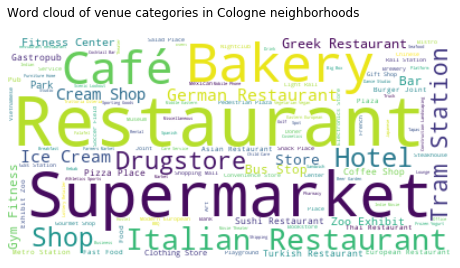

In [18]:
# generate the word cloud of venue categories in Cologne
vcategory_cologne = ', '.join(cologne_venues['Venue Category'])

title = 'Word cloud of venue categories in Cologne neighborhoods\n'
generateWordCloudPlotFor(vcategory_cologne, title)


In Düsseldorf:

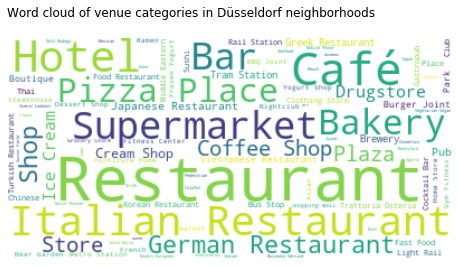

In [19]:
# generate the word cloud of venue categories in Düsseldorf
vcategory_dusseldorf = ', '.join(dusseldorf_venues['Venue Category'])

title = 'Word cloud of venue categories in Düsseldorf neighborhoods\n'
generateWordCloudPlotFor(vcategory_dusseldorf, title)


#### 2.4.2 Word-cloud plots of forgein restaurants in Cologne and Düsseldorf

In Cologne:

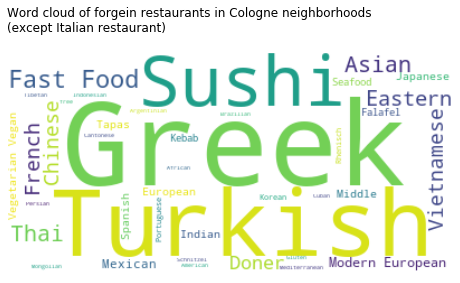

In [20]:
restaurant_venues = cologne_venues[cologne_venues['Venue Category'].str.contains("Restaurant")]

df_catRestaurant = pd.DataFrame(data=restaurant_venues['Venue Category'])
drop_str = "German|Italian"
index_drop = df_catRestaurant[df_catRestaurant['Venue Category'].str.contains(drop_str)].index
df_catRestaurant.drop(index_drop, inplace=True)

catRestaurant_in_cologne = ', '.join(df_catRestaurant['Venue Category'].str.replace("Restaurant", ""))

title = 'Word cloud of forgein restaurants in Cologne neighborhoods\n(except Italian restaurant)\n'
generateWordCloudPlotFor(catRestaurant_in_cologne, title)

In Düsseldorf:

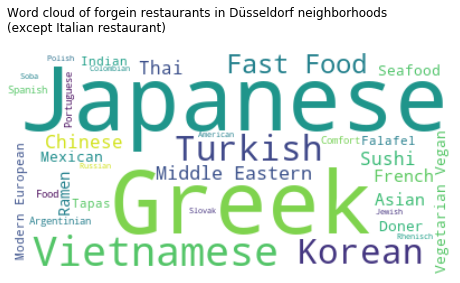

In [21]:
restaurant_venues = dusseldorf_venues[dusseldorf_venues['Venue Category'].str.contains("Restaurant")]

df_catRestaurant = pd.DataFrame(data=restaurant_venues['Venue Category'])
index_drop = df_catRestaurant[df_catRestaurant['Venue Category'].str.contains("German|Italian")].index
df_catRestaurant.drop(index_drop, inplace=True)

catRestaurant_in_dusseldorf = ', '.join(df_catRestaurant['Venue Category'].str.replace("Restaurant", ""))
title = 'Word cloud of forgein restaurants in Düsseldorf neighborhoods\n(except Italian restaurant)\n'
generateWordCloudPlotFor(catRestaurant_in_dusseldorf, title)

## 3 Comparison of neighborhoods in Cologne and Düsseldorf

### 3.0 Data preparation

#### Defining a function to prepare venue data

In [22]:
def onehotEncodingAndGrouping(df_venues):
    # one-hot encoding of dataframe df_venues
    df_onehot = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")
    df_onehot['Neighborhood'] = df_venues['Neighborhood'] 

    fixed_columns = [df_onehot.columns[-1]] + list(df_onehot.columns[:-1])
    df_onehot = df_onehot[fixed_columns]

    # grouping rows by neighborhood and by the mean of the frequency of occurence of each venue category
    df_grouped = df_onehot.groupby('Neighborhood').mean().reset_index()

    # checking size
    print('The one-hot encoded dataframe has {} rows and {} columns, and \nthe neighborhood-grouped one has {} rows and {} columns.'.format(df_onehot.shape[0], df_onehot.shape[1], df_grouped.shape[0], df_grouped.shape[1]))

    return df_grouped

#### 3.0.1 Preparing venue data from Cologne neighborhoods

In [23]:
cologne_venues_grouped = onehotEncodingAndGrouping(cologne_venues)

print('\nThe first 5 rows are:')

cologne_venues_grouped.head()

The one-hot encoded dataframe has 1104 rows and 206 columns, and 
the neighborhood-grouped one has 85 rows and 206 columns.

The first 5 rows are:


,Neighborhood,ATM,African Restaurant,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Vacation Rental,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Waterfront,Wine Bar,Wine Shop,Yoga Studio,Zoo,Zoo Exhibit
0,Altstadt-Nord,0.0,0.0,0.0,0.0,0.0,0.035294,0.0,0.023529,0.000000,...,0.0,0.011765,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,Altstadt-Süd,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.026316,0.000000,...,0.0,0.000000,0.0,0.026316,0.000000,0.0,0.0,0.0,0.0,0.0
2,Bayenthal,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.055556,0.0,0.0,0.0,0.0,0.0
3,Bickendorf,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.076923,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4,Bilderstöckchen,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


#### 3.0.2 Preparing venue data from Düsseldorf neighborhoods

In [24]:
dusseldorf_venues_grouped = onehotEncodingAndGrouping(dusseldorf_venues)
print('\nThe first 5 rows are:')

dusseldorf_venues_grouped.head()

The one-hot encoded dataframe has 891 rows and 172 columns, and 
the neighborhood-grouped one has 47 rows and 172 columns.

The first 5 rows are:


,Neighborhood,ATM,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,...,Trail,Tram Station,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Wine Bar,Women's Store,Yoga Studio
0,Altstadt,0.0,0.0,0.01,0.0,0.01,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.01,0.01,0.0
1,Angermund,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0
2,Benrath,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0
3,Bilk,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.210526,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0
4,Carlstadt,0.0,0.0,0.01,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.010000,0.0,0.0,0.01,0.0,0.0,0.02,0.01,0.0


### 3.1 Analyzing each neighborhood

#### 3.1.0 Defining functions to get most common venues for each neighborhood

In [25]:
# function to sort venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

def get_common_venues_from(neighborhood_grouped, num_top_venues):
    indicators = ['st', 'nd', 'rd']
    
    # create columns according to number of top venues
    columns = ['Neighborhood']
    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))

    # create a new dataframe
    neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
    neighborhoods_venues_sorted['Neighborhood'] = neighborhood_grouped['Neighborhood']

    for ind in np.arange(neighborhood_grouped.shape[0]):
        neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(neighborhood_grouped.iloc[ind, :], num_top_venues)

    return neighborhoods_venues_sorted


#### 3.1.1 Finding and printing the top 5 venues for each Cologne neighborhood

In [26]:
top_venues_in_cologne = get_common_venues_from(cologne_venues_grouped,5)
for idx in range(0,top_venues_in_cologne.shape[0]):
    print(top_venues_in_cologne.iloc[idx,:])
    print("\n")
    

ommon Venue            Bar
3rd Most Common Venue      Nightclub
4th Most Common Venue      Drugstore
5th Most Common Venue    Pizza Place
Name: 15, dtype: object


Neighborhood                           Eil
1st Most Common Venue    German Restaurant
2nd Most Common Venue             Bus Stop
3rd Most Common Venue           Steakhouse
4th Most Common Venue     Greek Restaurant
5th Most Common Venue       Shipping Store
Name: 16, dtype: object


Neighborhood                                Elsdorf
1st Most Common Venue                   Supermarket
2nd Most Common Venue    Construction & Landscaping
3rd Most Common Venue              Greek Restaurant
4th Most Common Venue                   Zoo Exhibit
5th Most Common Venue                Farmers Market
Name: 17, dtype: object


Neighborhood                    Ensen
1st Most Common Venue     Supermarket
2nd Most Common Venue           River
3rd Most Common Venue     Gas Station
4th Most Common Venue    Tram Station
5th Most Common Venue   

#### 3.1.2 Printing the top 5 venues for each Düsseldorf neighborhood


In [27]:
top_venues_in_dusseldorf = get_common_venues_from(dusseldorf_venues_grouped,5)
for idx in range(0,top_venues_in_dusseldorf.shape[0]):
    print(top_venues_in_dusseldorf.iloc[idx,:])
    print("\n")
    

Neighborhood                Altstadt
1st Most Common Venue            Bar
2nd Most Common Venue        Brewery
3rd Most Common Venue          Plaza
4th Most Common Venue    Coffee Shop
5th Most Common Venue           Café
Name: 0, dtype: object


Neighborhood                      Angermund
1st Most Common Venue    Light Rail Station
2nd Most Common Venue              Bus Stop
3rd Most Common Venue            Restaurant
4th Most Common Venue        Knitting Store
5th Most Common Venue       Bed & Breakfast
Name: 1, dtype: object


Neighborhood                      Benrath
1st Most Common Venue                Café
2nd Most Common Venue                 Pub
3rd Most Common Venue                Bank
4th Most Common Venue         Hockey Rink
5th Most Common Venue    Greek Restaurant
Name: 2, dtype: object


Neighborhood                         Bilk
1st Most Common Venue        Tram Station
2nd Most Common Venue               Hotel
3rd Most Common Venue    Greek Restaurant
4th Most Common Ven

### 3.2 Clustering the neighborhoods in Cologne by Foursquare venue data
#### 3.2.1 Running k-Means to cluster the neighborhoods
**Firstly, testing/Evaluating clustering with different number of clusters**

In [28]:
# Creating a new dataframe storing clustering scores
col_names = ['Number Of Clusters', 'Silhouette', 'Calinski-Harabasz', 'Davis-Bouldin']
scores_cologne = pd.DataFrame(columns=col_names)

X = cologne_venues_grouped.drop('Neighborhood', 1)

for kcluster in range(2, 11):
    # run k-means clustering
    kmeans_cologne = KMeans(n_clusters=kcluster, random_state=1).fit(X)
    labels = kmeans_cologne.labels_

    # evaluate and save clustering results
    scores_cologne = scores_cologne.append({
        'Number Of Clusters':kcluster, 
        'Silhouette':metrics.silhouette_score(X, labels, metric='euclidean'),
        'Calinski-Harabasz':metrics.calinski_harabasz_score(X, labels),
        'Davis-Bouldin':metrics.davies_bouldin_score(X, labels)
        }, ignore_index=True)

print('The K-means scores for clustering Cologne neighborhoods:   ')
scores_cologne.set_index('Number Of Clusters')


The K-means scores for clustering Cologne neighborhoods:   


,Silhouette,Calinski-Harabasz,Davis-Bouldin
Number Of Clusters,,,
2.0,0.475438,5.675185,0.385454
3.0,0.476550,6.016329,0.377985
4.0,0.117409,6.098941,1.179512
5.0,0.064519,6.502294,1.663366
6.0,0.066800,5.772340,1.478986
7.0,0.081562,6.455664,1.449834
8.0,0.037347,5.971648,1.944613
9.0,0.047399,5.776876,1.735322
10.0,0.050703,5.522333,1.608711


**Now, rerun k-means clustering with 5 clusters**

In [29]:
kclusters = 5
kmeans_cologne = KMeans(n_clusters=kclusters, random_state=1).fit(X)

# check cluster labels generated for each row in the dataframe
kmeans_cologne.labels_[0:]

array([1, 1, 4, 1, 4, 1, 1, 1, 4, 0, 4, 1, 1, 1, 4, 1, 1, 4, 4, 1, 1, 4,
       1, 0, 1, 0, 4, 0, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 4,
       1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 1, 1, 1, 4, 4, 1, 1, 1, 2,
       1, 1, 1, 1, 4, 1, 4, 1, 3, 4, 0, 1, 1, 1, 0, 1, 0, 1, 4])

#### 3.2.2 Visualizing the resulting clusters

Adding top venues and resulting cluster labels to dataframe and merging it with nb_cologne to add latitude and longitude coordinates

In [30]:
# add clustering labels
try:
    top_venues_in_cologne.drop('Cluster Labels', axis=1, inplace=True)    
    top_venues_in_cologne.insert(0, 'Cluster Labels', kmeans_cologne.labels_)
except:
    top_venues_in_cologne.insert(0, 'Cluster Labels', kmeans_cologne.labels_)

cologne_merged = nb_cologne.drop(columns={'Borough', 'Area', 'Population', 'Density'})
cologne_merged = cologne_merged.join(top_venues_in_cologne.set_index('Neighborhood'), on='Neighborhood')

cologne_merged.dropna(inplace=True)
cologne_merged['Cluster Labels'] = cologne_merged['Cluster Labels'].astype('int32')

cologne_merged.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Altstadt-Süd,50.929181,6.955329,1,Hotel,Café,Sushi Restaurant,Thai Restaurant,Convenience Store
1,Neustadt-Süd,50.926560,6.940406,1,Italian Restaurant,Bar,Bakery,Vietnamese Restaurant,Cocktail Bar
2,Altstadt-Nord,50.942265,6.953188,1,Bakery,Café,Italian Restaurant,Gift Shop,Gourmet Shop
3,Neustadt-Nord,50.947906,6.941059,1,Italian Restaurant,Sushi Restaurant,Park,Salad Place,Spanish Restaurant
4,Deutz,50.936759,6.973046,1,Bakery,Restaurant,Greek Restaurant,Café,Hotel


Visualizing the clusters on Cologne map

In [31]:
# create map
map_clusters = folium.Map(location=[lat_cg, long_cg], zoom_start=10, width='50%', height='50%')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cologne_merged['Latitude'].astype('float'), cologne_merged['Longitude'].astype('float'), cologne_merged['Neighborhood'], cologne_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

print('Map of Cologne superimposed with neighborhood clusters\n(num_of_clusters = 5)\n')
map_clusters

Map of Cologne superimposed with neighborhood clusters
(num_of_clusters = 5)



#### 3.2.3 Examining the resulting clusters

In [32]:
ilabel = 0

cologne_merged.loc[cologne_merged['Cluster Labels'] == ilabel, cologne_merged.columns[[0] + list(range(4, cologne_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
15,Godorf,Steakhouse,Hotel,Snack Place,Fast Food Restaurant,Tram Station
37,Longerich,Supermarket,Hotel,Gastropub,Bistro,Tram Station
51,Worringen,Supermarket,Hotel,Hobby Shop,Clothing Store,Zoo Exhibit
53,Westhoven,Hotel,Tram Station,Playground,Exhibit,Fountain
60,Grengel,Hotel,Business Service,Athletics & Sports,Cosmetics Shop,Zoo Exhibit
61,Wahnheide,Hotel,Italian Restaurant,Supermarket,Fast Food Restaurant,Greek Restaurant
78,Buchforst,Hotel,Supermarket,Bistro,Tram Station,Zoo Exhibit
80,Holweide,Hotel,Tram Station,Breakfast Spot,Ice Cream Shop,Pizza Place


### 3.3 Clustering the neighborhoods in Düsseldorf by Foursquare venue data
#### 3.3.1 Running k-Means to cluster the neighborhoods into groups
**Similar as before, testing/Evaluating clustering with different number of clusters in the first step**

In [33]:
# Creating a new dataframe storing clustering scores
col_names = ['Number Of Clusters', 'Silhouette', 'Calinski-Harabasz', 'Davis-Bouldin']
scores_dusseldorf = pd.DataFrame(columns=col_names)

X = dusseldorf_venues_grouped.drop('Neighborhood', 1)

for kcluster in range(2, 11):
    # run k-means clustering
    kmeans_dusseldorf = KMeans(n_clusters=kcluster, random_state=1).fit(X)
    labels = kmeans_dusseldorf.labels_

    # evaluate and save clustering results
    scores_dusseldorf = scores_dusseldorf.append({
        'Number Of Clusters':kcluster, 
        'Silhouette':metrics.silhouette_score(X, labels, metric='euclidean'),
        'Calinski-Harabasz':metrics.calinski_harabasz_score(X, labels),
        'Davis-Bouldin':metrics.davies_bouldin_score(X, labels)
        }, ignore_index=True)

print('The K-means scores for clustering Düsseldorf neighborhoods:   ')
scores_dusseldorf.set_index('Number Of Clusters')


The K-means scores for clustering Düsseldorf neighborhoods:   


,Silhouette,Calinski-Harabasz,Davis-Bouldin
Number Of Clusters,,,
2.0,0.330157,7.779359,1.029661
3.0,0.215921,6.286107,1.491451
4.0,0.187477,5.358672,1.368235
5.0,0.103620,5.316643,1.848780
6.0,0.103482,5.333614,1.526571
7.0,0.112444,4.998229,1.333148
8.0,0.081502,4.337789,1.117075
9.0,0.105221,4.320437,1.113701
10.0,0.074970,4.169485,1.475050


**Now, rerun k-means clustering with 4 clusters**

In [34]:
kclusters = 4
kmeans_dusseldorf = KMeans(n_clusters=kclusters, random_state=1).fit(X)

# check cluster labels generated for each row in the dataframe
kmeans_dusseldorf.labels_[0:]

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 3, 1, 1, 1, 0, 1, 2, 3, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 3,
       0, 1, 3])

#### 3.3.2 Visualizing the resulting clusters

Adding top venues and resulting cluster labels to dataframe and merging it with nb_dusseldorf to add latitude and longitude coordinates

In [35]:
# add clustering labels
try:
    top_venues_in_dusseldorf.drop('Cluster Labels', axis=1, inplace=True)    
    top_venues_in_dusseldorf.insert(0, 'Cluster Labels', kmeans_dusseldorf.labels_)
except:
    top_venues_in_dusseldorf.insert(0, 'Cluster Labels', kmeans_dusseldorf.labels_)

dusseldorf_merged = nb_dusseldorf.drop(columns={'Borough', 'Area', 'Population', 'Density'})
dusseldorf_merged = dusseldorf_merged.join(top_venues_in_dusseldorf.set_index('Neighborhood'), on='Neighborhood')

dusseldorf_merged.dropna(inplace=True)
dusseldorf_merged['Cluster Labels'] = dusseldorf_merged['Cluster Labels'].astype('int32')

dusseldorf_merged.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Altstadt,51.225912,6.773567,1,Bar,Brewery,Plaza,Coffee Shop,Café
1,Angermund,51.328995,6.781416,1,Light Rail Station,Bus Stop,Restaurant,Knitting Store,Bed & Breakfast
2,Benrath,51.163356,6.875192,1,Café,Pub,Bank,Hockey Rink,Greek Restaurant
3,Bilk,51.202758,6.785101,1,Tram Station,Hotel,Greek Restaurant,Café,Supermarket
4,Carlstadt,51.222142,6.773394,1,Italian Restaurant,Coffee Shop,Boutique,Café,Brewery


Visualizing the clusters on Düsseldorf map

In [36]:
# create map
map_clusters_dus = folium.Map(location=[lat_dus, long_dus], zoom_start=10, width='50%', height='50%')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dusseldorf_merged['Latitude'].astype('float'), dusseldorf_merged['Longitude'].astype('float'), dusseldorf_merged['Neighborhood'], dusseldorf_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_dus)
       
print('Map of Düsseldorf superimposed with neighborhood clusters\n(num_of_clusters = 4)\n')
map_clusters_dus

Map of Düsseldorf superimposed with neighborhood clusters
(num_of_clusters = 4)



#### 3.3.3 Examining the resulting clusters

In [37]:
ilabel = 3

dusseldorf_merged.loc[dusseldorf_merged['Cluster Labels'] == ilabel, dusseldorf_merged.columns[[0] + list(range(4, dusseldorf_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
27,Knittkuhl,Construction & Landscaping,German Restaurant,Pharmacy,Doner Restaurant,Food & Drink Shop
34,Niederkassel,Cultural Center,Brewery,German Restaurant,Trattoria/Osteria,Trail
45,Urdenbach,German Restaurant,Pub,Restaurant,Taverna,Discount Store
49,Wittlaer,German Restaurant,Bakery,Metro Station,Yoga Studio,French Restaurant


### 3.4 Clustering the neighborhoods in Cologne and Düsseldorf together
#### 3.4.1 Merging Foursquare venue data from Cologne and Düsseldorf into a new dataframe and preparing data for neighborhood clustering

In [38]:
# merging dataframe cologne_venues and dusseldorf_venues
df_venues = cologne_venues.append(dusseldorf_venues, ignore_index=True)

# one-hot encoding of dataframe df_venues and grouping rows by neighborhood and by the mean of the frequency of occurence of each venue category
venues_grouped = onehotEncodingAndGrouping(df_venues)
print('\nThe first 5 rows are:')
venues_grouped.head()

The one-hot encoded dataframe has 1995 rows and 246 columns, and 
the neighborhood-grouped one has 132 rows and 246 columns.

The first 5 rows are:


,Neighborhood,ATM,African Restaurant,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Waterfront,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Altstadt,0.0,0.0,0.0,0.01,0.0,0.010000,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.01,0.0,0.01,0.0,0.0,0.0
1,Altstadt-Nord,0.0,0.0,0.0,0.00,0.0,0.035294,0.0,0.023529,0.0,...,0.011765,0.0,0.000000,0.000000,0.00,0.0,0.00,0.0,0.0,0.0
2,Altstadt-Süd,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.026316,0.0,...,0.000000,0.0,0.026316,0.000000,0.00,0.0,0.00,0.0,0.0,0.0
3,Angermund,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.00,0.0,0.00,0.0,0.0,0.0
4,Bayenthal,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.055556,0.00,0.0,0.00,0.0,0.0,0.0


#### 3.4.2 Finding the top 5 venue categories for each neighborhood

In [39]:
top_venues_in_neighborhoods = get_common_venues_from(venues_grouped,5)
for idx in range(0,top_venues_in_neighborhoods.shape[0]):
    print(top_venues_in_neighborhoods.iloc[idx,:])
    print("\n")


ench Restaurant
Name: 62, dtype: object


Neighborhood              Lichtenbroich
1st Most Common Venue    Clothing Store
2nd Most Common Venue       Supermarket
3rd Most Common Venue         Drugstore
4th Most Common Venue       Pizza Place
5th Most Common Venue       Zoo Exhibit
Name: 63, dtype: object


Neighborhood                    Lierenfeld
1st Most Common Venue     Business Service
2nd Most Common Venue    Food & Drink Shop
3rd Most Common Venue          Pizza Place
4th Most Common Venue         Tram Station
5th Most Common Venue          Zoo Exhibit
Name: 64, dtype: object


Neighborhood                               Lind
1st Most Common Venue    Furniture / Home Store
2nd Most Common Venue          Business Service
3rd Most Common Venue                   Dog Run
4th Most Common Venue               Zoo Exhibit
5th Most Common Venue        Falafel Restaurant
Name: 65, dtype: object


Neighborhood                       Lindenthal
1st Most Common Venue      Italian Restaurant
2n

#### 3.4.3 Running k-Means to cluster the neighborhoods
**Firstly, testing/Evaluating clustering with different number of clusters**

In [40]:
# Creating a new dataframe storing clustering scores
col_names = ['Number Of Clusters', 'Silhouette', 'Calinski-Harabasz', 'Davis-Bouldin']
kmeans_scores = pd.DataFrame(columns=col_names)

X = venues_grouped.drop('Neighborhood', 1)

for kcluster in range(2, 11):
    # run k-means clustering
    kmeans_clustering = KMeans(n_clusters=kcluster, random_state=0).fit(X)
    labels = kmeans_clustering.labels_

    # evaluate and save clustering results
    kmeans_scores = kmeans_scores.append({
        'Number Of Clusters': str(kcluster), 
        'Silhouette':metrics.silhouette_score(X, labels, metric='euclidean'),
        'Calinski-Harabasz':metrics.calinski_harabasz_score(X, labels),
        'Davis-Bouldin':metrics.davies_bouldin_score(X, labels)
        }, ignore_index=True)

print('The K-means scores for clustering neighborhoods of Cologne and Düsseldorf:   ')
kmeans_scores.set_index('Number Of Clusters')


The K-means scores for clustering neighborhoods of Cologne and Düsseldorf:   


,Silhouette,Calinski-Harabasz,Davis-Bouldin
Number Of Clusters,,,
2,0.072934,11.378889,2.762288
3,0.079881,8.674134,2.576729
4,0.056277,7.262962,2.488516
5,0.089117,7.859925,2.107350
6,0.090120,7.942384,1.677770
7,0.090369,6.850351,1.905293
8,0.043809,6.320566,2.098879
9,0.095852,6.617653,1.426177
10,0.074890,6.359462,1.735066


**Then, rerun k-means clustering with 9 clusters**

In [41]:
kclusters = 9
kmeans_clustering = KMeans(n_clusters=kclusters, random_state=0).fit(X)

# check cluster labels generated for each row in the dataframe
kmeans_clustering.labels_[0:]

array([7, 7, 7, 7, 0, 7, 7, 1, 2, 7, 1, 7, 0, 2, 7, 7, 7, 7, 7, 7, 0, 7,
       7, 0, 0, 0, 1, 7, 7, 7, 7, 0, 7, 7, 0, 1, 2, 7, 7, 7, 2, 7, 7, 1,
       7, 0, 0, 7, 0, 2, 0, 7, 0, 7, 2, 1, 7, 7, 7, 7, 7, 7, 8, 0, 7, 4,
       7, 7, 2, 2, 0, 2, 1, 2, 0, 7, 1, 1, 6, 7, 7, 7, 7, 7, 7, 7, 2, 0,
       7, 7, 0, 0, 7, 1, 7, 7, 0, 1, 0, 4, 0, 7, 7, 3, 7, 7, 7, 7, 7, 7,
       0, 1, 7, 0, 7, 7, 0, 0, 7, 5, 0, 2, 7, 7, 1, 0, 2, 7, 7, 0, 7, 0])

#### 3.4.4 Visualizing the resulting clusters

_Adding top venues and resulting cluster labels to dataframe and merging it with df_venues to add latitude and longitude coordinates_

In [42]:
# add clustering labels
try:
    top_venues_in_neighborhoods.drop('Cluster Labels', axis=1, inplace=True)
    top_venues_in_neighborhoods.insert(0, 'Cluster Labels', kmeans_clustering.labels_)
except:    
    top_venues_in_neighborhoods.insert(0, 'Cluster Labels', kmeans_clustering.labels_)

df_merged = pd.DataFrame(columns={'Neighborhood','Latitude','Longitude'})
df_merged = df_venues[{'Neighborhood','Latitude','Longitude'}].groupby('Neighborhood').mean().reset_index()

df_merged = df_merged.join(top_venues_in_neighborhoods.set_index('Neighborhood'), on='Neighborhood')

df_merged.dropna(inplace=True)
df_merged['Cluster Labels'] = df_merged['Cluster Labels'].astype('int32')

df_merged.reset_index()
df_merged.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Altstadt,51.225913,6.773567,7,Brewery,Bar,Café,Plaza,Coffee Shop
1,Altstadt-Nord,50.942265,6.953188,7,Bakery,Café,Italian Restaurant,Gift Shop,Coffee Shop
2,Altstadt-Süd,50.929181,6.955329,7,Hotel,Café,Sushi Restaurant,Convenience Store,Thai Restaurant
3,Angermund,51.328995,6.781416,7,Bed & Breakfast,Bus Stop,Restaurant,Bar,Knitting Store
4,Bayenthal,50.911058,6.969238,0,Supermarket,Bakery,Drugstore,German Restaurant,Ice Cream Shop


_Visualizing the clusters on map_

In [43]:
# create map
latitude = (lat_cg + lat_dus)/2
longitude = (long_cg + long_dus)/2
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=9.4, width='50%', height='50%')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merged['Latitude'].astype('float'), df_merged['Longitude'].astype('float'), df_merged['Neighborhood'], df_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
print('Map of Cologne and Düsseldorf superimposed with neighborhood clusters\n(num_of_clusters = 9)\n')
map_clusters

Map of Cologne and Düsseldorf superimposed with neighborhood clusters
(num_of_clusters = 9)



#### 3.4.5 Examining the resulting clusters

In [44]:
ilabel = 2

df_merged.loc[df_merged['Cluster Labels'] == ilabel, df_merged.columns[[0] + list(range(4, df_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
8,Bilk,Tram Station,Hotel,Café,Greek Restaurant,Supermarket
13,Buchforst,Hotel,Tram Station,Supermarket,Bistro,Zoo Exhibit
36,Godorf,Snack Place,Hotel,Tram Station,Steakhouse,Fast Food Restaurant
40,Grengel,Hotel,Business Service,Cosmetics Shop,Athletics & Sports,Zoo Exhibit
49,Holweide,Hotel,Tram Station,Ice Cream Shop,Pizza Place,Breakfast Spot
54,Itter,Mobile Phone Shop,Construction & Landscaping,Bus Stop,Hotel,Fast Food Restaurant
68,Lohausen,Athletics & Sports,Sports Bar,Event Service,Hotel,Falafel Restaurant
69,Longerich,Hotel,Gastropub,Tram Station,Supermarket,Bistro
71,Lörick,Hotel,Italian Restaurant,Asian Restaurant,Restaurant,Bakery
73,Marienburg (Köln),Italian Restaurant,Harbor / Marina,History Museum,Plaza,Hotel


**The clustering results indicated that the neighborhoods in Cologne and Düsseldorf are not well distinguished by their venue data.**

**The neighborhood analysis based on Foursquare venue data suggests that Cologne and Düsseldorf are very similar, and there is no real rivalry in everyday life.**